# Droplet Generation System. Hydraulic part

Continue model tuning [model_policy_reinforce.pkl](https://github.com/mvulf/drop_control/blob/main/models/model_policy_reinforce.pkl) and save it as [model_policy_reinforce_updated.pkl](https://github.com/mvulf/drop_control/blob/main/models/model_policy_reinforce_updated.pkl). Continuation is required since previous notebook freezes (solve_ivp with a very small time step near the zero-action).

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import torch
# Dataset - to create own dataset, DataLoader - for batch generation
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal

import random
from typing import Tuple, Dict, Optional, Callable, Type, Any

from tqdm.notebook import tqdm
from IPython.display import clear_output

# System implementation

In [2]:
class HydraulicSystem:
    """System class: hydraulic system. State transition function"""
    
    dim_action: int = 1
    dim_observation: int = 2
    dim_state: int = 2
    
    x_th_eps: float = 0.5 # backslash (should be as small as possible)
    dx_th_eps: float = 0.1 # used as limit for positions checking
    
    # Real throttle position limits
    # if throttle is opened
    x_th_limits = [0, 20] # [µm]
    # Policy update time
    dt_update_action = 1.0e-4 # s
    # Max throttle speed
    v_th_max = 0.5*(x_th_limits[1] - x_th_limits[0])/dt_update_action # µm/s
    
    m_p: float = 20e-3 # kg
    p_atm: float = 1e5 # Pa
    p_l: float = 1.5e5 + p_atm # Pa
    p_h_init: float = p_atm # Pa
    g: float = 9.81 # m/s^2
    F_g = m_p*g # N
    
    # Geometry
    D_th: float = 200e-6 # Equivalent throttle diameter, m
    D_h: float = 20e-3 # m
    D_t: float = 20e-3 # m
    D_exit: float = 0.33e-3 # m
    l_exit: float = 8.5e-3 # m
    get_area = lambda D: np.pi*D**2/4 # returns area in [m^2], if input in [m]
    A_h = get_area(D_h)
    A_t = get_area(D_t)
    A_max = max(A_h, A_t)
    D_t_exit_2_ratio = D_t**2/D_exit**2
    
    # Friction params
    p_c: float = 10e3 # Pressure difference on the piston to start movement, Pa
    eta: float = 0.70 # Mechanical efficiency
    F_c = p_c * A_max # Coulomb friction force, N
    
    # Hydraulic coeficients
    zeta_th = 5.0 # might be find empirically (from real equipment). Now it is taken for the valve, see 'Идельчик И. Е. Справочник по гидравлическим сопротивлениям. М., "Машиностроение", 1975'
    C_D = 0.827 - 0.0085*l_exit/D_exit # see https://doi.org/10.1201/9781420040470
    zeta_exit = 1/C_D**2
    
    # Let us consider water as hydraulic and test liquid
    rho_h = 1e3 # kg/m^3
    rho_t = 1e3 # kg/m^3
    
    p_sv_h: float = 2340 # Pa
    
    beta_v_h: float = 0.49e-9 # Pa^-1
    beta_v_t: float = 0.49e-9 # Pa^-1
    
    sigma_t: float = 73e-3 # N/m
    mu_t: float = 1.0e-3 # Pa*s
    
    # capillar pressure difference to othercome for drop exiting
    p_capillar_max = 4*sigma_t/D_exit
    
    v_j = 200. # jet speed for the stable operation (found experimentaly) [mm/s]
    We_j = rho_t*v_j**2*D_exit/(1e6*sigma_t)
    Re_j = rho_t*v_j*D_exit/(1e3*mu_t)
    Oh_j = np.sqrt(We_j)/Re_j
    # Critical jet length
    # l_crit = 19.5*np.sqrt(We_j)*(1 + 3*Oh_j)**0.85 * D_exit # see https://doi.org/10.1201/9781420040470
    l_crit = 13.4e3*(np.sqrt(We_j) + 3*We_j/Re_j) * D_exit # see https://doi.org/10.1007/s00348-003-0629-6
    # Estimated Droplet diameter
    D_drop = 1e3*(1.5*np.pi*np.sqrt(2 + 3*Oh_j))**(1/3) * D_exit
    
    # Coefs of pressure losses
    ploss_coef_h = (zeta_th*rho_h*D_h**4)/(32*D_th**2)
    ploss_coef_t = (zeta_exit*rho_t*D_t**4)/(2e12*D_exit**4)
    
    def __init__(self) -> None:
        """Initialize Hydraulic System"""
        self.reset()
    
    
    def reset(self) -> None:
        """Reset system to initial state."""
        
        # p_h|_{x_{th}>0}
        self.p_h_last = self.p_h_init
        # x_p|_{x_{th}>0}
        self.x_p_last = None # define later, if None
        # Initial piston position
        self.x_p_init = None # define later, if None
    
        
    def get_pressure_hydraulic(self, x_p: float, v_p: float, x_th: float) -> float:
        """ Get pressure in the hydraulic container

        Args:
            x_p (float): piston position [µm]
            v_p (float): piston velocity [µm/s]
            x_th (float): throttle position [µm]

        Returns:
            float: pressure in the hydraulic container [Pa]
        """
        
        # Define last piston position first time as init piston position
        if self.x_p_last is None:
            self.x_p_last = x_p
        
        # Calculate
        if x_th > 0:
            pressure_hydraulic = self.p_l
            # dynamic pressure loss happends only when there is a flow rate
            if v_p != 0: 
                # self.x_th_eps refers to somekind of backslash
                pressure_hydraulic -= v_p*(abs(v_p)/\
                    (x_th+self.x_th_eps)**2)*self.ploss_coef_h
        else:
            assert x_p > 0, 'piston position might be positive'
            pressure_hydraulic = self.p_h_last +\
                (self.x_p_last/x_p - 1)/self.beta_v_h
        # Pressure cannot be smaller than saturated vapor pressure
        pressure_hydraulic = max(self.p_sv_h, pressure_hydraulic)
        # if pressure_hydraulic == self.p_sv_h:
        #     print('WARNING: low hydraulic pressure')
        #     print(f'dx_p = {x_p - self.x_p_init:.3e}')
        #     print(f'v_p = {v_p:.3e}')
        
        # Save piston position and hydraulic pressure if throttle is opened
        if x_th > 0:
            self.x_p_last = x_p
            self.p_h_last = pressure_hydraulic
        return pressure_hydraulic
    
    
    def get_pressure_test(self, x_p: float, v_p: float) -> float:
        """ Get pressure in the test container

        Args:
            x_p (float): piston position [µm]
            v_p (float): piston velocity [µm/s]

        Returns:
            float: pressure in the test container [Pa]
        """
        
        assert x_p > 0, 'piston position might be positive'
        # Define init piston position, if it is first time
        if self.x_p_init is None:
            self.x_p_init = x_p
        
        # Position difference
        dx_p = x_p - self.x_p_init
        
        pressure_capillar = min(
            self.p_capillar_max, 
            abs(dx_p/x_p)/self.beta_v_t
        )
        # print(f'pressure_capillar = {pressure_capillar}')
        # print(f'p_capillar_max = {self.p_capillar_max}')
        
        pressure_test = self.p_atm + np.sign(dx_p) * pressure_capillar
            
        # dynamic pressure loss happends only when there is a flow rate
        if v_p != 0:
            pressure_test += v_p*abs(v_p) * self.ploss_coef_t
        
        return pressure_test
        
    
    def get_force_hydraulic(self, x_p: float, v_p: float, x_th: float) -> float:
        """ Get hydraulic force acting on the piston

        Args:
            x_p (float): piston position [µm]
            v_p (float): piston velocity [µm/s]
            x_th (float): throttle position [µm]

        Returns:
            float: hydraulic force [N]
        """
        
        # if x_p <= 0:
        #     _ = 2
        
        p_h = self.get_pressure_hydraulic(x_p, v_p, x_th)
        p_t = self.get_pressure_test(x_p, v_p)
        
        return self.A_h*p_h - self.A_t*p_t
        
    
    def get_force_friction(self, v_p: float, F_h: float) -> float:
        """ Get friction force acting on the piston

        Args:
            v_p (float): piston velocity [µm/s]
            F_h (float): Hydraulic force [N]

        Returns:
            float: friction force [N]
        """
        
        if v_p > 0:
            return - np.sign(v_p) * max(self.F_c, (1-self.eta)*F_h)
        # If piston does not move
        return -np.sign(self.F_g + F_h) * self.F_c
    
    
    def get_acceleration(self, x_p: float, v_p: float, x_th: float) -> float:
        """ Get piston acceleration

        Args:
            x_p (float): piston position [µm]
            v_p (float): piston velocity [µm/s]
            x_th (float): throttle position [µm]

        Returns:
            float: piston acceleration [m/s^2]
        """
        F_h = self.get_force_hydraulic(x_p, v_p, x_th)
        F_fr = self.get_force_friction(v_p, F_h)
        
        # print(f'F_h = {F_h}')
        # print(f'F_fr = {F_fr}')
        
        if (abs(v_p) > 0) or (abs(F_h + self.F_g) > abs(F_fr)):
            return (self.g + 1/self.m_p * (F_h + F_fr))*1e6
        return 0 # if piston does not move and acting force lower than friction
    
    
    def compute_dynamics(self, state: np.array, action: np.array) -> np.array:
        """Calculate right-hand-side (rhs) for ODE solver (or Euler integrator)

        Args:
            state (np.array): current state
            action (np.array): current action

        Returns:
            np.array: rhs for the ODE solver
        """
        
        # Get states
        x_p = state[0]
        v_p = state[1]
        # real throttle position
        # If real throttle position out of bounds - end throttle movement and set in bounds
        x_th = max(self.x_th_limits[0], state[2])
        x_th = min(self.x_th_limits[1], x_th)
        
        # Get and modify action
        x_th_act = max(self.x_th_limits[0], action[0]) # consider negative action as closed throttle
        # For expanded actions
        x_th_act = min(self.x_th_limits[1], x_th_act)
        assert (x_th_act >= self.x_th_limits[0]) and (x_th_act <= self.x_th_limits[1]), 'action out of the bounds'
        
        # Get Dstates
        Dstate = np.zeros(self.dim_state + 1) # just to include an emplicit state (current throttle position)
        # \dot{x_th}
        # if real throttle position is differ from the set one, change it
        if abs(x_th_act - x_th) > self.dx_th_eps:
            # if x_th_act > 0:
            #     Dstate[2] = np.sign(x_th_act - x_th) * self.v_th_max
            # else: # if set x_th_act == 0
            #     Dstate[2] = -self.v_th_max if x_th > 0 else 0
            Dstate[2] = np.sign(x_th_act - x_th) * self.v_th_max
        else:
            x_th = x_th_act # set throttle position exact as what we want to act
            Dstate[2] = 0
        
        # \dot{x_p}
        Dstate[0] = v_p
        # \dot{v_p}
        Dstate[1] = self.get_acceleration(x_p, v_p, x_th)
        
        return Dstate
    
    
    def get_jet_velocity(self, v_p: float) -> float:
        """Get exit jet velocity

        Args:
            v_p (float): piston velocity [µm/s]

        Returns:
            float: exit jet velocity [mm/s]
        """
        return 1e-3 * v_p * self.D_t_exit_2_ratio
    
    
    def get_jet_length(self, x_p: float) -> float:
        """Get objective (jet length (which necessary to compare with l_crit))

        Args:
            x_p (float): piston position [µm]

        Returns:
            float: objective [mm]
        """
        return 1e-3 * (x_p - self.x_p_init) * self.D_t_exit_2_ratio
    
    
    def get_observation(self, state: np.array) -> np.array:
        """Get observation (relative jet length)

        Args:
            state (np.array): system state

        Returns:
            np.array: observation
        """
        x_p = state[0]
        v_p = state[1]
        
        # Define init piston position, if it is first time
        if self.x_p_init is None:
            self.x_p_init = x_p
        
        observation = np.zeros(self.dim_observation)
        observation[0] = self.get_jet_length(x_p) / self.l_crit
        # add relative velocity
        observation[1] = self.get_jet_velocity(v_p) / self.l_crit *\
            self.dt_update_action
        
        return observation

# Simulator

Let us implement it with ODE-solver

In [3]:
class Simulator:
    """Integrator"""
    
    def __init__(
        self,
        system: HydraulicSystem,
        N_steps: int,
        state_init: np.array,
        step_size: float = 1e-4, # s
        time_scale_first = 1e-6, # 1e-9 , for the first step
        time_scale_max = np.inf, # 1e-4, # for the max step in solve_ivp
        atol = 1e-7,
        rtol = 1e-4,
    ):
        self.system = system
        self.N_steps = N_steps
        self.step_size = step_size
        
        if time_scale_first is None:
            self.first_step = None # solve_ivp will choose first time step
        else:
            # define first step for the solve_ivp
            self.first_step = time_scale_first * step_size
        self.max_step = time_scale_max*step_size # max_step for the ivp
        self.atol = atol
        self.rtol = rtol
        
        self.state_init = np.zeros(system.dim_state+1) # add one state for the x_th (real)
        self.state_init[:-1] = state_init.copy()
        
        self.reset()
        
    
    def reset(self) -> None:
        """Resets the system to initial state"""
        self.current_step_idx = 0
        self.state = self.state_init.copy()
        self.action = np.zeros(self.system.dim_action)
        self.system.reset()
    
    
    def set_action(self, action: np.array) -> None:
        """ Save current action to 'self.action'

        Args:
            action (np.array): current action
        """
        self.action = action.copy()
    
    
    def system_transition_function(self, state: np.array, action: np.array) -> np.array:
        """ Ger next state by the action

        Args:
            state (np.array): system state
            action (np.array): system action

        Returns:
            np.array: next state
        """
        def rhs(t: float, y: np.array) -> np.array:
            """ Get rhs (Dstates) for the ode-solver

            Args:
                t (float): time
                y (np.array): state (in scipy notation)

            Returns:
                np.array: rhs (Dstates) for the ode-solver
            """
            return self.system.compute_dynamics(y, action)
        
        next_state = solve_ivp(
            fun=rhs, 
            t_span=(0, self.step_size), 
            y0=state,
            first_step=self.first_step,
            max_step=self.max_step,
            rtol=self.rtol,
            atol=self.atol,
        ).y.T[-1]
        
        return next_state
    
    
    def step(self) -> bool:
        """ Do one integration step with step_size

        Returns:
            bool: status of simulation. 'True' - simulation continues, 'False' - simulation stopped
        """
        
        if self.current_step_idx <= self.N_steps:
            self.state = self.system_transition_function(self.state, self.action)
            self.current_step_idx += 1
            return True
        return False
    
    
    def get_sim_step_data(self) -> Tuple[int, np.array, np.array]:
        """ Get current step id, observation and action

        Returns:
            Tuple[int, np.array, np.array]: _description_
        """
        
        return (
            int(self.current_step_idx),
            self.system.get_observation(self.state),
            np.copy(self.action)
        )
    
    def get_state_step_data(self) -> np.array:
        return self.state.copy()

## Test simulator

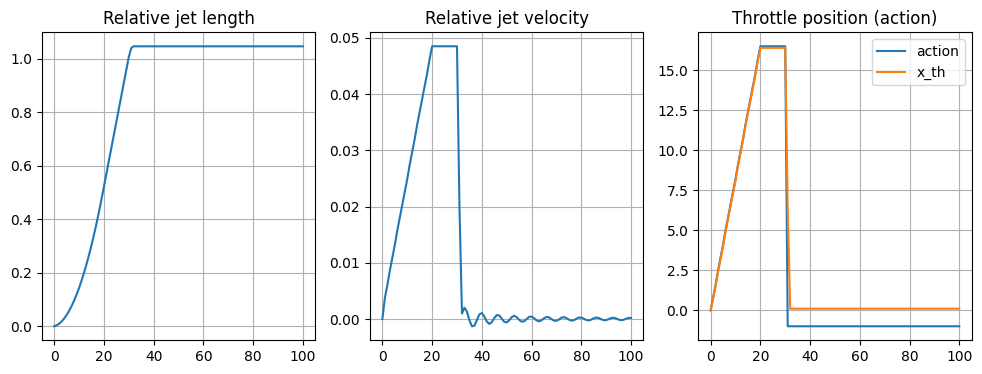

In [4]:
system = HydraulicSystem()
simulator = Simulator(system, N_steps=100, state_init=np.array([1e3, 0]))

observations = []
actions = []
states = []

while simulator.step():
    (
        step_idx,
        observation,
        action,
    ) = simulator.get_sim_step_data()
    
    state = simulator.get_state_step_data()
    
    # if simulator.current_step_idx < 20:
    #     new_action = np.array([5.])
    # elif simulator.current_step_idx < 32:
    #     new_action = np.array([10.0])
    # elif simulator.current_step_idx < 40:
    #     new_action = np.array([16.0])
    # else:
    #     new_action = np.array([0])
    
    step_idx_max = 20
    
    if simulator.current_step_idx <= step_idx_max:
        new_action = np.array([16.5 * simulator.current_step_idx/step_idx_max])
    elif simulator.current_step_idx <= step_idx_max + 10:
        new_action = np.array([16.5])
    else:
        new_action = np.array([-1.])
    
    new_action = np.round(new_action,1)
    
    simulator.set_action(new_action)
    observations.append(observation)
    actions.append(action)
    states.append(state)

states_arr = np.array(states)

fig, (ax_length, ax_velocity, ax_action) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax_length.plot(np.array(observations)[:,0])
ax_length.grid()
ax_length.set_title('Relative jet length')

ax_velocity.plot(np.array(observations)[:,1])
ax_velocity.grid()
ax_velocity.set_title('Relative jet velocity')

ax_action.plot(np.array(actions)[:, 0], label='action')
ax_action.plot(states_arr[:, 2], label='x_th')
ax_action.grid()
ax_action.set_title('Throttle position (action)');
ax_action.legend();

# Experience replay

Let us save all our observations and actions for gradient descent step

In [5]:
class IterationBuffer(Dataset):
    """Buffer for experience replay"""

    def __init__(self) -> None:
        """Initialize `IterationBuffer`"""

        super().__init__()
        self.next_baselines = None
        self.nullify_buffer()


    def nullify_buffer(self) -> None:
        """Clear all buffer data"""

        self.episode_ids = []
        self.observations = []
        self.actions = []
        self.running_objectives = []
        self.step_ids = []
        self.total_objectives = None
        self.baselines = None
    
      
    def add_step_data(
        self,
        observation: np.array,
        action: np.array,
        running_objective: float,
        step_id: int,
        episode_id: int,
    ):
        """Add step data to experience replay

        Args:
            observation (np.array): current observation
            action (np.array): current action
            running_objective (float): current running objective
            step_id (int): current step
            episode_id (int): current episode
        """
        self.observations.append(observation)
        self.actions.append(action)
        self.running_objectives.append(running_objective)
        self.episode_ids.append(int(episode_id))
        self.step_ids.append(step_id)
        
    
    def get_N_episodes(self) -> int:
        """Get number of episodes

        Returns:
            int: number of episodes
        """
        return len(np.unique(self.episode_ids))
    
    
    def calculate_tail_total_objectives_and_next_baselines(
        self,
    ) -> Tuple[np.array, float, float]:
        """Calculate tail total costs and baseline

        Returns:
            Tuple[np.array, float, float]: tuple of 3 elements # 2 elements, without gradent_normalization_constant
            tail_total_objectives, baseline, gradent_normalization_constant
        """

        unique_episode_ids = np.unique(self.episode_ids)
        # We will have the same indexes in pd.Series
        running_objectives_series = pd.Series(
            index=self.episode_ids, data=self.running_objectives
        )
        
        # Sum of inverted rows in one episode for all episodes (like summation from the end)
        # Then - invert to get tail sums for each element!
        tail_total_objectives = pd.concat(
            [
                running_objectives_series.loc[i][::-1].cumsum()[::-1]
                for i in unique_episode_ids
            ]
        ).values.reshape(-1)

        # already gothern tail sums for each episode
        # Thus, we need to get an average of tail sums on all episodes for each step 
        next_baselines = (
            pd.Series(index=self.step_ids, data=tail_total_objectives)
            .groupby(level=0) # group by indexes
            .mean()
            .loc[self.step_ids] # expand means on steps of all episodes
            .values.reshape(-1)
        )

        return tail_total_objectives, next_baselines


    def __len__(self) -> int:
        """Get length of buffer. The method should be overrided due to inheritance from `torch.utils.data.Dataset`

        Returns:
            int: length of buffer
        """
        return len(self.observations)


    def __getitem__(self, idx: int) -> Dict[str, torch.tensor]:
        """Get item with id `idx`. The method should be overrided due to inheritance from `torch.utils.data.Dataset`

        Args:
            idx (int): id of dataset item to return

        Returns:
            Dict[str, torch.tensor]: dataset item, containing catted observation-action, tail total objective and baselines
        """
        
        # If total_objectives are not filled out, fill out them and next_baselines
        if self.total_objectives is None:
            # Take baseline from next_baseline if the latter exists
            self.baselines = (
                self.next_baselines
                if self.next_baselines is not None
                else np.zeros(shape=len(self.observations))
            )

            (
                self.total_objectives,
                self.next_baselines,
            ) = self.calculate_tail_total_objectives_and_next_baselines()

        observation = torch.tensor(self.observations[idx])
        action = torch.tensor(self.actions[idx])

        return {
            "observations_actions": torch.cat([observation, action]).float(),
            "tail_total_objectives": torch.tensor(self.total_objectives[idx]).float(),
            "baselines": torch.tensor(self.baselines[idx]).float(),
        }


    @property
    def data(self) -> pd.DataFrame:
        """Return current buffer content in pandas.DataFrame

        Returns:
            pd.DataFrame: current buffer content
        """

        return pd.DataFrame(
            {
                "episode_id": self.episode_ids,
                "step_id": self.step_ids,
                "observation": self.observations,
                "action": self.actions,
                "running_objective": self.running_objectives,
            }
        )

# NN Model for policy

TODO: add \sigma(\mu(y)) plot

The policy model will be taken as:

$$
    \rho
$$

In [6]:
class GaussianPDFModel(nn.Module):
    """Model for REINFORCE algorithm that acts like f(x) + normally distributed noise"""

    def __init__(
        self,
        dim_observation: int,
        dim_action: int,
        dim_hidden: int,
        std: float,
        action_bounds: np.array,
        scale_factor: float,
        leakyrelu_coef=0.2,
    ):
        """Initialize model.

        Args:
            dim_observation (int): dimensionality of observation
            dim_action (int): dimensionality of action
            dim_hidden (int): dimensionality of hidden layer of perceptron (dim_hidden = 4 works for our case)
            std (float): standard deviation of noise (\\sigma)
            action_bounds (np.array): action bounds with shape (dim_action, 2). `action_bounds[:, 0]` - minimal actions, `action_bounds[:, 1]` - maximal actions
            scale_factor (float): scale factor for last activation (L coefficient) (see details above)
            leakyrelu_coef (float): coefficient for leakyrelu
        """

        super().__init__()

        self.dim_observation = dim_observation
        self.dim_action = dim_action
        self.dim_hidden = dim_hidden
        self.leakyrelu_coef = leakyrelu_coef
        self.std = std

        self.scale_factor = scale_factor
        self.register_parameter(
            name="scale_tril_matrix",
            param=torch.nn.Parameter(
                (self.std * torch.eye(self.dim_action)).float(),
                requires_grad=False,
            ),
        )
        self.register_parameter(
            name="action_bounds",
            param=torch.nn.Parameter(
                torch.tensor(action_bounds).float(),
                requires_grad=False,
            ),
        )


        #-----------------------------------------------------------------------
        # HINT
        #
        # Define your perceptron (or its layers) here
        #
        # TAs used nn.Sequential(...)
        # https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

        self.mu_nn = nn.Sequential(
            nn.Linear(self.dim_observation, self.dim_hidden),
            nn.LeakyReLU(self.leakyrelu_coef),
            nn.Linear(self.dim_hidden, self.dim_hidden),
            nn.LeakyReLU(self.leakyrelu_coef),
            nn.Linear(self.dim_hidden, self.dim_action),
            # nn.Tanh(), # (1-3\sigma) transformations might be later
        )
        # init last activation layer
        self.tanh = nn.Tanh()

        #-----------------------------------------------------------------------



    def get_unscale_coefs_from_minus_one_one_to_action_bounds(
        self,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Calculate coefficients for linear transformation from [-1, 1] to [U_min, U_max].

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: coefficients
        """

        action_bounds = self.get_parameter("action_bounds")
        #-----------------------------------------------------------------------
        # HINT
        #
        # You need to return a tuple of \\beta, \\lambda
        #
        # Note that action bounds are denoted above as [U_min, U_max]
        #
        u_min = self.action_bounds[:,0]
        u_max = self.action_bounds[:,1]
        
        beta_ = (u_min + u_max)/2
        lambda_ = (u_max - u_min)/2
        
        return beta_, lambda_

        #-----------------------------------------------------------------------

    def unscale_from_minus_one_one_to_action_bounds(
        self, x: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [-1, 1] to [U_min, U_max].

        Args:
            x (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return x * unscale_multiplier + unscale_bias

    def scale_from_action_bounds_to_minus_one_one(
        self, y: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [U_min, U_max] to [-1, 1].

        Args:
            y (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return (y - unscale_bias) / unscale_multiplier

    def get_means(self, observations: torch.FloatTensor) -> torch.FloatTensor:
        """Return mean for MultivariateNormal from `observations`

        Args:
            observations (torch.FloatTensor): observations

        Returns:
            torch.FloatTensor: means
        """

        #-----------------------------------------------------------------------
        # HINT
        #
        # You should return here exactly the \\mu_theta(observations)
        
        # First - make forward step with current observations
        nn_result = self.mu_nn(observations)
        # Then, divide by scale_factor (L) and put into the nn.Tanh()
        mu_activation = self.tanh(nn_result/self.scale_factor)
        # Then multiply by (1 - 3*std)
        ## [WRONG] to multiply by (1 - 3*self.scale_tril_matrix)
        return (1 - 3*self.std)*mu_activation
        
        #-----------------------------------------------------------------------



    def split_to_observations_actions(
        self, observations_actions: torch.FloatTensor
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Split input tensor to tuple of observation(s) and action(s)

        Args:
            observations_actions (torch.FloatTensor): tensor of catted observations actions to split

        Raises:
            ValueError: in case if `observations_actions` has dimensinality greater than 2

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: tuple of observation(s) and action(s)
        """

        if len(observations_actions.shape) == 1:
            observation, action = (
                observations_actions[: self.dim_observation],
                observations_actions[self.dim_observation :],
            )
        elif len(observations_actions.shape) == 2:
            observation, action = (
                observations_actions[:, : self.dim_observation],
                observations_actions[:, self.dim_observation :],
            )
        else:
            raise ValueError("Input tensor has unexpected dims")

        return observation, action

    def get_unscale_mean_and_variance(
        self, 
        observations: torch.FloatTensor,
        scale_tril_matrix: torch.nn.parameter.Parameter,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """ Get unscaled mean and covariance matrix for the pdf_Normal

        Args:
            observations (torch.FloatTensor): observations batch
            scale_tril_matrix (torch.nn.parameter.Parameter): covariance matrix

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: Unscaled mean and covariance matrix for the pdf_Normal
        """
        # Get means in range [-1, 1]
        mu_scaled = self.get_means(observations)

        # Return back to the action range [U_min, U_max]
        mu_unscaled = self.unscale_from_minus_one_one_to_action_bounds(mu_scaled)
        # Get lambda
        (
            _,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()
        
        # Get unscaled lower-triangular factor of covariance
        tril_unscaled = unscale_multiplier * scale_tril_matrix
        
        return mu_unscaled, tril_unscaled
        
        

    def log_probs(self, batch_of_observations_actions: torch.FloatTensor) -> torch.FloatTensor:
        """Get log pdf from the batch of observations actions

        Args:
            batch_of_observations_actions (torch.FloatTensor): batch of catted observations and actions

        Returns:
            torch.FloatTensor: log pdf(action | observation) for the batch of observations and actions
        """

        observations, actions = self.split_to_observations_actions(
            batch_of_observations_actions
        )

        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        #-----------------------------------------------------------------------
        # HINT
        # You should calculate pdf_Normal(\\lambda \\mu_theta(observations) + \\beta, \\lambda ** 2 \\sigma ** 2)(actions)
        #
        # TAs used not NormalDistribution, but MultivariateNormal
        # See here https://pytorch.org/docs/stable/distributions.html#multivariatenormal
        
        # Get unscaled mean and variance
        (
            mu_unscaled, 
            tril_unscaled
        ) = self.get_unscale_mean_and_variance(observations, scale_tril_matrix)
        
        # Get set of pdfs
        multi_norm = MultivariateNormal(
            loc=mu_unscaled, # \\lambda \\mu_theta(observations) + \\beta
            scale_tril=tril_unscaled, # \\lambda \\sigma
        )
        # actions = actions.squeeze() # Get one-dim vector
        # Calculate log pdf(action | observation)
        return multi_norm.log_prob(actions)

        #-----------------------------------------------------------------------


    def sample(self, observation: torch.FloatTensor) -> torch.FloatTensor:
        """Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)`

        Args:
            observation (torch.FloatTensor): current observation

        Returns:
            torch.FloatTensor: sampled action
        """
        action_bounds = self.get_parameter("action_bounds")
        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        #-----------------------------------------------------------------------
        # HINT
        # Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)

        # Get unscaled mean and variance
        (
            mu_unscaled, 
            tril_unscaled
        ) = self.get_unscale_mean_and_variance(observation, scale_tril_matrix)
        
        # Get set of pdfs
        multi_norm = MultivariateNormal(
            loc=mu_unscaled, # \\lambda \\mu_theta(observations) + \\beta
            scale_tril=tril_unscaled, # \\lambda \\sigma
        )
        
        sampled_action = multi_norm.rsample()

        #-----------------------------------------------------------------------
        return torch.clamp(
            sampled_action, action_bounds[:, 0], action_bounds[:, 1]
        )

# Optimizer

In [7]:
class LRSchedulerSwitch:
    """Callable class that returns True in case ||observation|| <= norm_observation_threshold"""

    def __init__(self, norm_observation_threshold: float) -> None:
        """Initialize LRSchedulerSwitch.

        Args:
            norm_observation_threshold (float): threshold for observation norm
        """
        self.norm_observation_threshold = norm_observation_threshold
        self.turned_on = False

    def __call__(self, observation: np.array) -> bool:
        """Return True if ||observation|| <= norm_observation_threshold

        Args:
            observation (np.array): observation

        Returns:
            bool: ||observation|| <= norm_observation_threshold
        """

        if (
            self.turned_on
            or np.linalg.norm(observation) <= self.norm_observation_threshold
        ):
            self.turned_on = True
            return True
        else:
            return False


class Optimizer:
    """Does gradient step for optimizing model weights"""

    def __init__(
        self,
        model: nn.Module,
        opt_method: Type[torch.optim.Optimizer],
        opt_options: Dict[str, Any],
        lr_scheduler_method: Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        lr_scheduler_options: Optional[Dict[str, Any]] = None,
        lr_scheduler_switch: Callable[[np.array], bool] = lambda _: True,
        shuffle: bool = False,
    ):
        """Initialize Optimizer

        Args:
            model (nn.Module): model which weights we need to optimize
            opt_method (Type[torch.optim.Optimizer]): method type for optimization. For instance, `opt_method=torch.optim.SGD`
            opt_options (Dict[str, Any]): kwargs dict for opt method
            lr_scheduler_method (Optional[torch.optim.lr_scheduler.LRScheduler], optional): method type for LRScheduler. Defaults to None
            lr_scheduler_options (Optional[Dict[str, Any]], optional): kwargs for LRScheduler. Defaults to None
            lr_scheduler_switch (Callable[[np.array], bool]): callable object for turning on the sheduller. Defaults to lambda _: True
            shuffle (bool, optional): whether to shuffle items in dataset. Defaults to True
        """

        self.opt_method = opt_method
        self.opt_options = opt_options
        self.shuffle = shuffle
        self.model = model
        self.optimizer = self.opt_method(self.model.parameters(), **self.opt_options)
        self.lr_scheduler_method = lr_scheduler_method
        self.lr_scheduler_options = lr_scheduler_options
        self.lr_scheduler_switch = lr_scheduler_switch
        if self.lr_scheduler_method is not None:
            self.lr_scheduler = self.lr_scheduler_method(
                self.optimizer, **self.lr_scheduler_options
            )
        else:
            self.lr_scheduler = None

    def optimize(
        self,
        objective: Callable[[torch.tensor], torch.tensor],
        dataset: IterationBuffer,
    ) -> None:
        """Do gradient step.

        Args:
            objective (Callable[[torch.tensor], torch.tensor]): objective to optimize
            dataset (Dataset): data for optmization
        """

        dataloader = DataLoader(
            dataset=dataset,
            shuffle=self.shuffle,
            batch_size=len(dataset),
        )
        batch_sample = next(iter(dataloader))
        self.optimizer.zero_grad()
        objective_value = objective(batch_sample)
        objective_value.backward()
        self.optimizer.step()

        last_observation = dataset.observations[-1]
        if self.lr_scheduler_switch(last_observation) and self.lr_scheduler is not None:
            self.lr_scheduler.step()

# Policy

In [8]:
class PolicyREINFORCE:
    def __init__(
        self, model: nn.Module, optimizer: Optimizer, device: str = "cpu", is_with_baseline: bool = True,
    ) -> None:
        """Initialize policy

        Args:
            model (nn.Module): model to optimize
            optimizer (Optimizer): optimizer for `model` weights optimization
            device (str, optional): device for gradient descent optimization procedure. Defaults to "cpu".
            is_with_baseline (bool, optional): whether to use baseline in objective function.
        """

        self.buffer = IterationBuffer()
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.is_with_baseline = is_with_baseline

    def objective(self, batch: Dict["str", torch.tensor]) -> torch.tensor:
        """This method computes a proxy objective specifically for automatic differentiation since its gradient is exactly as in REINFORCE

        Args:
            batch (torch.tensor): batch with catted observations-actions, total objectives and baselines

        Returns:
            torch.tensor: objective value
        """

        observations_actions = batch["observations_actions"].to(self.device)
        tail_total_objectives = batch["tail_total_objectives"].to(self.device)
        baselines = batch["baselines"].to(self.device)
        N_episodes = self.N_episodes
        #-----------------------------------------------------------------------
        # HINT
        # Return the surrogate objective value as described above
        
        # Get log probs of policy
        log_probs = self.model.log_probs(observations_actions)
        
        return 1/N_episodes*((tail_total_objectives - baselines)*log_probs).sum()

        #-----------------------------------------------------------------------

    def REINFORCE_step(self) -> None:
        """Do gradient REINFORCE step"""

        self.N_episodes = self.buffer.get_N_episodes()
        self.model.to(self.device)
        self.optimizer.optimize(self.objective, self.buffer)
        self.model.to("cpu")
        self.buffer.nullify_buffer()

# Monte Carlo Simulation Scenario (class for main loop)

In [9]:
class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        simulator: Simulator,
        system: HydraulicSystem,
        policy: PolicyREINFORCE,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (InvertedPendulumSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running objectives. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_objective, total_objectove. Defaults to lambda*args:False
        """

        self.simulator = simulator
        self.system = system
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor

        self.total_objective = 0
        self.total_objectives_episodic = []
        self.learning_curve = []
        self.last_observations = None

    def compute_running_objective(
        self, observation: np.array, action: np.array
    ) -> float:
        """Computes running objective

        Args:
            observation (np.array): current observation
            action (np.array): current action

        Returns:
            float: running objective value
        """
        
        length_diff = (1 - observation[0])
        
        # If length larger than critical, penalty for the positive velocity
        # Velocity must be not positive
        # if length_diff < 0:
        #     velocity_objective = 1e4 * observation[1] * abs(observation[1])
        # else:
        #     velocity_objective = 0

        # If length smaller than critical, penalty for the negative velocity
        # If length larger than critical, penalty for the positive velocity
        return length_diff ** 2 -\
            np.sign(length_diff) * observation[1] * abs(observation[1]) * 1e2

    def run(self) -> None:
        """Run main loop"""

        eps = 0.1
        means_total_objectives = [eps]
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            for episode_idx in tqdm(range(self.N_episodes)):
                terminated = False
                while self.simulator.step():
                    (
                        step_idx,
                        observation,
                        action,
                    ) = self.simulator.get_sim_step_data()

                    new_action = (
                        self.policy.model.sample(torch.tensor(observation).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    discounted_running_objective = self.discount_factor ** (
                        step_idx
                    ) * self.compute_running_objective(observation, new_action)
                    self.total_objective += discounted_running_objective

                    if not terminated and self.termination_criterion(
                        observation,
                        new_action,
                        discounted_running_objective,
                        self.total_objective,
                    ):
                        terminated = True

                    if not terminated:
                        self.policy.buffer.add_step_data(
                            np.copy(observation),
                            np.copy(new_action),
                            np.copy(discounted_running_objective),
                            step_idx,
                            episode_idx,
                        )
                    self.simulator.set_action(new_action)
                self.simulator.reset()
                self.total_objectives_episodic.append(self.total_objective)
                self.total_objective = 0
            self.learning_curve.append(np.mean(self.total_objectives_episodic))
            self.last_observations = pd.DataFrame(
                index=self.policy.buffer.episode_ids,
                data=self.policy.buffer.observations.copy(),
            )
            self.last_actions = pd.DataFrame(
                index=self.policy.buffer.episode_ids,
                data=self.policy.buffer.actions.copy(),
            )
            self.policy.REINFORCE_step()

            means_total_objectives.append(np.mean(self.total_objectives_episodic))
            change = (means_total_objectives[-1] / means_total_objectives[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_objectives[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}, "
                + f"last observation: {self.last_observations.iloc[-1].values.reshape(-1)}",
                end="\n",
            )

            self.total_objectives_episodic = []

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        plt.yscale("log")
        plt.show()

        ax_jet_length, ax_jet_velocity = pd.DataFrame(
            data=self.last_observations.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Observations in last iteration",
            legend=False,
            subplots=True,
            grid=True,
        )
        ax_jet_length.set_ylabel("relative jet length")
        ax_jet_velocity.set_ylabel("relative jet velocity")

        ax_actions = pd.DataFrame(
            data=self.last_actions.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Actions in last iteration",
            legend=False,
            grid=True,
        )
        ax_actions.set_ylabel("action")

        plt.show()

# Run simulation and fit REINFORCE

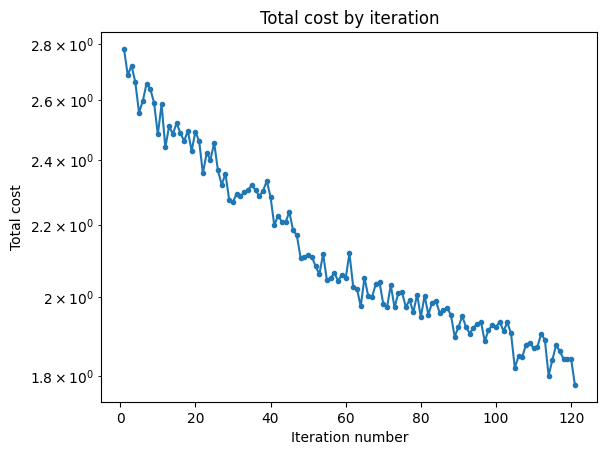

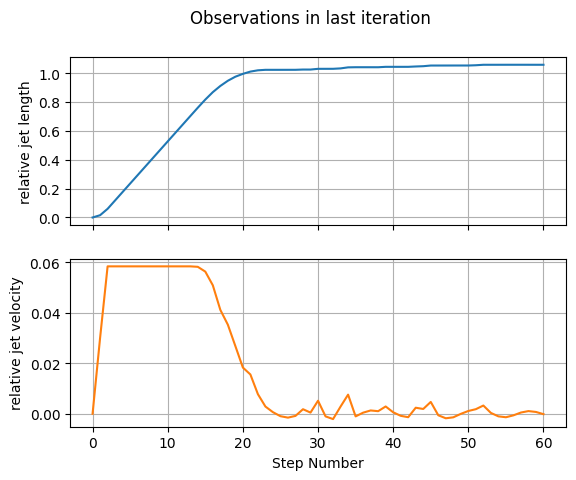

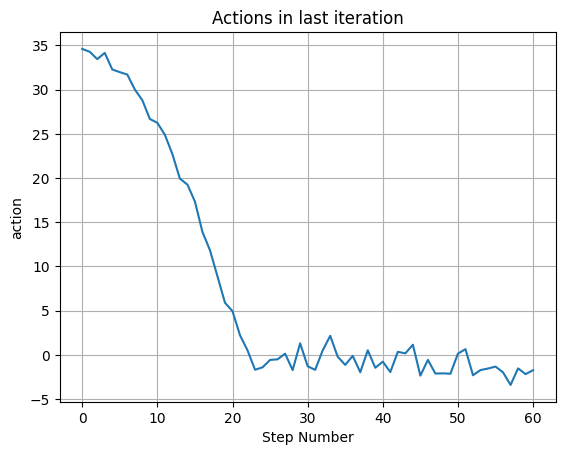

In [10]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = HydraulicSystem()
## DO NOT CHANGE THE PARAMS OF SIMULATOR.
simulator = Simulator(
    system, N_steps=60, state_init=np.array([1e3, 0.0])
)
# model = GaussianPDFModel(
#     dim_observation=system.dim_observation,
#     dim_action=system.dim_action,
#     action_bounds=np.array([[-40., 40]]), # These actions are expanded in comparison with real action
#     #---------------------------------------------------------------------------
#     # YOUR CODE GOES HERE
#     scale_factor=10.0,  # TRY TO FIND scale_factor EMPIRICALLY
#     dim_hidden=2, # TRY TO FIND dim_hidden EMPIRICALLY
#     std=0.02, # TRY TO FIND STD EMPIRICALLY
#     #---------------------------------------------------------------------------
# )

# LET US UPLOAD PRETRAINED model
model = torch.load('../data/model_policy_reinforce.pkl')

optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=1.0e-2), # TRY TO FIND lr EMPIRICALLY
    #---------------------------------------------------------------------------
)
## Or if you want to use scheduler then initialize optimizer, via, for instance
# lr_scheduler_fading_coeff = 1
# optimizer = Optimizer(
#     model=model,
#     opt_method=torch.optim.Adam,
#     opt_options=dict(lr=1.0, betas=(0.8, 0.9)),
#     shuffle=False,
#     lr_scheduler_method=torch.optim.lr_scheduler.MultiplicativeLR,
#     lr_scheduler_options={
#         "lr_lambda": lambda iteration: 1
#         / np.sqrt((iteration / lr_scheduler_fading_coeff) ** 2 + 1)
#     },
#     lr_scheduler_switch=LRSchedulerSwitch(norm_observation_threshold=0.1),
# )
#
# BELEIVE US! YOU CAN SOLVE THIS TASK WITHOUT SCHEDULER

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_terminantion_criterion = lambda *args: False

## EXAMPLE. This termination criterion terminates episode if observation norm >= 20
#
# termination_criterion = (
#     lambda observation, action, running_objective, total_objective: (
#         np.linalg.norm(observation) >= 20
#     )
# )
#
# DO NOT USE TERMINATION CRITERION OTHER THAN trivial_termination_criterion


scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    N_episodes=2, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=200, # You can change the number of iterations if you want
    #---------------------------------------------------------------------------
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=1.0, # do not change this
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

In [12]:
torch.save(model, '../data/model_policy_reinforce_updated.pkl')

Do not forget to save this module!

# APPLICATION

OLD State dynamics function

State dynamics function is:
$$
    \begin{aligned}
        &   \dot{x_p} = \begin{cases} v_p, \text{ if } [x_{th} > 0] \text{ and } [F_h(v_p, x_{th}) > |F_{fr}(v_p, x_{th})|] \\
                        0, \text{ otherwise }\end{cases}
        \\
        &   \dot{v_p} = \begin{cases} \frac{1}{m_p}[F_h(v_p, x_{th}) + F_{fr}(v_p, x_{th})], \text{ if } [x_{th} > 0] \text{ and } [F_h(v_p, x_{th}) > |F_{fr}(v_p, x_{th})|] \\
                        0, \text{ otherwise }\end{cases}
    \end{aligned}
    \qquad x_{th} \in [0, x_{th}^{max}],
$$

where (if $x_{th}>0$):
$$
    \begin{aligned}
        &   F_h(v_p, x_{th}) = \left[p_l - \frac{\zeta_{th}\rho_h D_h^4}{32D_{th}^2}\left(\frac{v_p}{x_{th}}\right)^2 \right]A_h - \left[p_{atm} + \frac{\zeta_{exit}\rho_t D_t^4}{2D_{exit}^4}v_p^2 \right]A_t, \\
        &   F_{fr}(v_p, x_{th}) = -\frac{v_p}{|v_p|}\max{[p_C\cdot A_{max}, (1-\eta)\cdot F_h(v_p, x_{th})]}. \\
    \end{aligned}
$$

where $A_{max} = \max{(A_h, A_t)}$